In [234]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import datetime as dt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split




In [235]:
class SDOBenchmarkDataset(Dataset):
    """
    Generates data for PyTorch.
    Inspired by https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
    """
    def __init__(self, base_path, transform=None, augment=False, label_func=None, data_format="channels_last"):
        """
        Initialization.
        :param base_path: Path to the dataset directory.
        :param transform: Optional transform to be applied on a sample.
        :param augment: Whether to augment the data by flipping horizontally.
        :param label_func: Optional function to transform labels.
        :param data_format: Data format, either 'channels_last' or 'channels_first'.
        """
        self.base_path = base_path
        self.transform = transform
        self.label_func = label_func
        self.data_format = data_format
        self.channels = ['magnetogram']  # Assuming only magnetogram data
        self.time_steps = [0, 7*60, 10*60+30, 11*60+50]  # Time steps in minutes
        self.data = self.loadCSV(augment)  # Load metadata
        self.on_epoch_end()

    def loadCSV(self, augment=True):
        """
        Load metadata from CSV file and optionally augment the data.
        :param augment: Whether to augment the data by flipping horizontally.
        :return: DataFrame containing metadata.
        """
        data = pd.read_csv(os.path.join(self.base_path, 'meta_data_processed.csv'), sep=",", parse_dates=["start", "end"], index_col="id")
        # Augment by doubling the data and flagging them to be flipped horizontally
        data['flip'] = False
        if augment:
            new_data = data.copy()
            new_data.index += '_copy'
            new_data['flip'] = True
            data = pd.concat([data, new_data])
        return data
    

    
    def on_epoch_end(self):
        """
        Updates indexes after each epoch.
        """
        self.indexes = np.arange(len(self.data))
        np.random.shuffle(self.indexes)

    def loadImg(self, sample_id):
        """
        Load the images of each timestep as channels.
        :param sample_id: ID of the sample.
        :return: Numpy array containing the images.
        """
        ar_nr, p = sample_id.replace('_copy', '').split("_", 1)
        path = os.path.join(self.base_path, ar_nr, p)

        slices = np.zeros((4, 256, 256))  # Initialize slices for 4 time steps

        if not os.path.exists(path):
            print(f"路径不存在: {path}")
            return slices

        sample_date = dt.datetime.strptime(p[:p.rfind('_')], "%Y_%m_%d_%H_%M_%S")
        time_steps = [sample_date + dt.timedelta(minutes=offset) for offset in self.time_steps]
        for img in [name for name in os.listdir(path) if name.endswith('.jpg')]:
            try:
                img_datetime_raw, img_wavelength = os.path.splitext(img)[0].split("__")
                img_datetime = dt.datetime.strptime(img_datetime_raw, "%Y-%m-%dT%H%M%S")

                # Calculate wavelength and datetime index
                datetime_index = [di[0] for di in enumerate(time_steps) if abs(di[1] - img_datetime) < dt.timedelta(minutes=15)]
                if img_wavelength in self.channels and len(datetime_index) > 0:
                    img_path = os.path.join(path, img)
                    val = np.array(Image.open(img_path).convert('L'))  # Load grayscale image
                    if val.shape != (256, 256):
                        print(f"图像形状不正确: {img_path}, 形状: {val.shape}")
                        continue

                    if self.data_format == 'channels_last':
                        slices[datetime_index[0], :, :] = val
                    else:
                        slices[:, :, datetime_index[0]] = val
            except Exception as e:
                print(f"加载图像时出错: {img_path}, 错误信息: {e}")

        return slices

    def __len__(self):
        """
        Denotes the number of samples.
        """
        return len(self.data)

    def __getitem__(self, index):
        """
        Generates one sample of data.
        :param index: Index of the sample.
        :return: Tuple (X, y) where X is the input data and y is the label.
        """
        # Load data and get label
        sample_id = self.data.index[index]
        X = self.loadImg(sample_id)
        y = self.data.loc[sample_id, 'standard_peak_flux']

        # Apply label function if provided
        if self.label_func is not None:
            y = self.label_func(y)

        # Data augmentation
        if self.data.loc[sample_id, 'flip']:
            X = np.flip(X, axis=2).copy()  # Horizontal flip and copy to avoid modifying the original array

        # Convert to tensor
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        # Apply transform if any
        if self.transform:
            X = self.transform(X)

        return X, y


In [236]:
import numpy as np
import math
from sklearn.metrics import confusion_matrix

goes_classes = ['quiet', 'A', 'B', 'C', 'M', 'X']

def flux_to_class(f: float, only_main=False):
    if f == 0:
        return 'quiet'
    if f < 0:
        # 打印出引起错误的值
        print(f"Error: Non-positive flux value detected in flux_to_class: {f:15f}")
        raise ValueError("Flux value must be positive for logarithm calculation.")
    decade = int(min(math.floor(math.log10(f)), -4))
    sub = round(10 ** -decade * f)
    if decade < -4:  # avoiding class 10
        decade += sub // 10
        sub = max(sub % 10, 1)
    main_class = goes_classes[decade + 9] if decade >= -8 else 'quiet'
    sub_class = str(sub) if main_class != 'quiet' and only_main != True else ''
    return main_class + sub_class

def class_to_flux(c: str):
    if c == 'quiet':
        return 1e-9
    decade = goes_classes.index(c[0]) - 9
    sub = float(c[1:]) if len(c) > 1 else 1
    return round(10 ** decade * sub, 10)

def true_skill_statistic(y_true, y_pred, threshold='M'):
    separator = class_to_flux(threshold)
    y_true = [1 if yt >= separator else 0 for yt in y_true]
    y_pred = [1 if yp >= separator else 0 for yp in y_pred]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn) - fp / (fp + tn)

def heidke_skill_score(y_true, y_pred, threshold='M'):
    separator = class_to_flux(threshold)
    y_true = [1 if yt >= separator else 0 for yt in y_true]
    y_pred = [1 if yp >= separator else 0 for yp in y_pred]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (tp + fn) / len(y_pred) * (tp + fp) / len(y_pred) + (tn + fn) / len(y_pred) * (tn + fp) / len(y_pred)


In [237]:
# 定义 base path
base_path = '/home/AIIAcourse/course/231503031/flare_prediction/data/archive/SDOBenchmark_full/'
#检查样本数据分布

train_df = pd.read_csv(os.path.join(base_path, "training/meta_data.csv")).copy()
test_df = pd.read_csv(os.path.join(base_path, "test/meta_data.csv")).copy()


max_peak_flux = max(train_df['peak_flux'].max(), test_df['peak_flux'].max())
min_peak_flux = min(train_df['peak_flux'].min(), test_df['peak_flux'].min())
#打印样本分布
print(f'通量最大值为 {max_peak_flux}')
print(f'通量最小值为 {min_peak_flux}')


#标准化样本分布
from sklearn.preprocessing import StandardScaler

train_df['log_peak_flux'] = np.log(train_df['peak_flux'])
test_df['log_peak_flux'] = np.log(test_df['peak_flux'])

print(f'取对数后通量最大值为 {max(train_df["log_peak_flux"].max(), test_df["log_peak_flux"].max())}')
print(f'取对数后通量最小值为 {min(train_df["log_peak_flux"].min(), test_df["log_peak_flux"].min())}')


scaler = StandardScaler()
train_df['standard_peak_flux'] = scaler.fit_transform(train_df['log_peak_flux'].values.reshape(-1, 1))
test_df['standard_peak_flux'] = scaler.transform(test_df['log_peak_flux'].values.reshape(-1, 1))

def denormalize_peak_flux(x, scaler):
    return scaler.inverse_transform(x.reshape(-1, 1)).flatten()


print(f'标准化后通量最大值为 {max(train_df["standard_peak_flux"].max(), test_df["standard_peak_flux"].max())}')
print(f'标准化后通量最小值为 {min(train_df["standard_peak_flux"].min(), test_df["standard_peak_flux"].min())}')

#打印标准化后的样本分布
#25%分位数
print(f'25%分位数: {np.percentile(train_df["standard_peak_flux"], 25)}')
print(f'75%分位数: {np.percentile(train_df["standard_peak_flux"], 75)}')

#去掉所有在标准化后小于-0.5的样本
train_df = train_df[train_df['standard_peak_flux']>-1]
test_df = test_df[test_df['standard_peak_flux']>-1]

# 提取标准化后的标签
train_labels = train_df['standard_peak_flux'].values
test_labels = test_df['standard_peak_flux'].values


#将处理后的训练集和验证集保存到csv文件
train_df.to_csv(os.path.join(base_path, "training/meta_data_processed.csv"), index=False)
test_df.to_csv(os.path.join(base_path, "test/meta_data_processed.csv"), index=False)


'''
#可视化样本分布
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制直方图
plt.figure(figsize=(10, 6))
sns.histplot(train_df['peak_flux'], bins=100, alpha=0.5, label='training set')
sns.histplot(test_df['peak_flux'], bins=100, alpha=0.5, label='validation set')
plt.title('distrubution of peak flux')
plt.xlabel('peak flux')
plt.ylabel('frequency')
plt.xlim(1.1*min(train_df['peak_flux'].min(), test_df['peak_flux'].min()), 1.1*max(train_df['peak_flux'].max(), test_df['peak_flux'].max()))
plt.legend()


# 绘制直方图
plt.figure(figsize=(10, 6))
sns.histplot(train_df['standard_peak_flux'], bins=100, alpha=0.5, label='training set')
sns.histplot(test_df['standard_peak_flux'], bins=100, alpha=0.5, label='validation set')
plt.title('distrubution of peak flux(standardized)')
plt.xlabel('standardized peak flux')
plt.ylabel('frequency')
plt.xlim(1.1*min(train_df['standard_peak_flux'].min(), test_df['standard_peak_flux'].min()), 1.1*max(train_df['standard_peak_flux'].max(), test_df['standard_peak_flux'].max()))
plt.legend()
plt.show()
'''

通量最大值为 0.0010941176470588
通量最小值为 1e-09
取对数后通量最大值为 -6.8178070423192185
取对数后通量最小值为 -20.72326583694641
标准化后通量最大值为 2.4720720876181956
标准化后通量最小值为 -1.100167580966047
25%分位数: -1.100167580966047
75%分位数: 0.8524645244562409


"\n#可视化样本分布\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# 绘制直方图\nplt.figure(figsize=(10, 6))\nsns.histplot(train_df['peak_flux'], bins=100, alpha=0.5, label='training set')\nsns.histplot(test_df['peak_flux'], bins=100, alpha=0.5, label='validation set')\nplt.title('distrubution of peak flux')\nplt.xlabel('peak flux')\nplt.ylabel('frequency')\nplt.xlim(1.1*min(train_df['peak_flux'].min(), test_df['peak_flux'].min()), 1.1*max(train_df['peak_flux'].max(), test_df['peak_flux'].max()))\nplt.legend()\n\n\n# 绘制直方图\nplt.figure(figsize=(10, 6))\nsns.histplot(train_df['standard_peak_flux'], bins=100, alpha=0.5, label='training set')\nsns.histplot(test_df['standard_peak_flux'], bins=100, alpha=0.5, label='validation set')\nplt.title('distrubution of peak flux(standardized)')\nplt.xlabel('standardized peak flux')\nplt.ylabel('frequency')\nplt.xlim(1.1*min(train_df['standard_peak_flux'].min(), test_df['standard_peak_flux'].min()), 1.1*max(train_df['standard_peak_flux'].max(), test_df

In [238]:
# 定义 transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize grayscale image
    #torchvision.transforms.RandomRotation(degrees = 180)
])

# 加载数据集
train_dataset = SDOBenchmarkDataset(
    base_path=os.path.join(base_path, "training"),
    transform=transform,
    augment=True,
    label_func=None,
    data_format="channels_last"
)

test_dataset = SDOBenchmarkDataset(
    base_path=os.path.join(base_path, "test"),
    transform=transform,
    augment=False,
    label_func=None,
    data_format="channels_last"
)

# 划分训练集和验证集
train_size = int(0.8 * len(train_dataset))  # 80% 作为训练集
val_size = len(train_dataset) - train_size   # 20% 作为验证集

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


# Check dataset length and sample
print(f"训练集样本数量: {len(train_dataset)}")
sample_X, sample_y = train_dataset[0]
print(f"样本 X 的形状: {sample_X.shape}")
print(f"样本 y 的值: {sample_y}")


print(f"测试集样本数量: {len(test_dataset)}")
sample_X, sample_y = test_dataset[0]
print(f"样本 X 的形状: {sample_X.shape}")
print(f"样本 y 的值: {sample_y}")


print(f"验证集样本数量: {len(val_dataset)}")
sample_X, sample_y = val_dataset[0]
print(f"样本 X 的形状: {sample_X.shape}")
print(f"样本 y 的值: {sample_y}")




训练集样本数量: 7496
样本 X 的形状: torch.Size([4, 256, 256])
样本 y 的值: 0.9616147875785828
测试集样本数量: 638
样本 X 的形状: torch.Size([4, 256, 256])
样本 y 的值: 1.1970051527023315
验证集样本数量: 1874
样本 X 的形状: torch.Size([4, 256, 256])
样本 y 的值: 0.852464497089386


In [239]:
import torch.nn as nn
import torch.optim as optim

# 定义 CNN 模型
class FlareCNN(nn.Module):
    def __init__(self):
        super(FlareCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        #self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        #self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        #self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(65536, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
    '''包含bn
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        #x = x.view((-1, 64 * 128 * 128))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = torch.exp(x)
        return x
    '''
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        #x = x.view((-1, 64 * 128 * 128))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = torch.exp(x)
        return x
    

# 初始化模型
model = FlareCNN()

# 检查设备
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model.to(device)

print(model)


Using cuda:1 device
FlareCNN(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [240]:
# batch_size = 16, lr = 0.001, epochs = 20 accuracy = 0.2638
# 16, 0.001 ,30 accuracy = 0.2616
# 32, 0,001, 30 accuracy = 0.2638
# 64, 0.001, 30 0.2583
# 64, 0.0005, 50 0.26
# 32, 0.001 , 40 0.


# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
log_train_loss_list = []
log_val_loss_list = []
# 训练模型
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 零梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        running_loss += loss.item()
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 10 == 0:  # 每 10 个批次打印一次
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/10:}')
            running_loss = 0

    train_loss_avg = train_loss/len(train_loader)
    #log_train_loss_list.append(train_loss_avg)
    log_train_loss_list.append(np.log(train_loss_avg))
            
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss_avg:.12f}')

    # 计算在验证集上的 loss
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    val_loss_avg = val_loss / len(val_loader)
    #log_val_loss_list.append(val_loss_avg)
    log_val_loss_list.append(np.log(val_loss_avg))
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss_avg:.12f}')

#储存模型
torch.save(model.state_dict(), 'CNN.pth')
    
    


/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/40], Step [10/235], Loss: 0.12751358300447463
Epoch [1/40], Step [20/235], Loss: 0.11017510555684566
Epoch [1/40], Step [30/235], Loss: 0.1188556931912899
Epoch [1/40], Step [40/235], Loss: 0.11849648356437684
Epoch [1/40], Step [50/235], Loss: 0.08960733860731125
Epoch [1/40], Step [60/235], Loss: 0.13393443301320077
Epoch [1/40], Step [70/235], Loss: 0.10682563483715057
Epoch [1/40], Step [80/235], Loss: 0.10973731800913811
Epoch [1/40], Step [90/235], Loss: 0.12672381103038788
Epoch [1/40], Step [100/235], Loss: 0.09757363721728325
Epoch [1/40], Step [110/235], Loss: 0.10302647352218627
Epoch [1/40], Step [120/235], Loss: 0.09267238378524781
Epoch [1/40], Step [130/235], Loss: 0.10267131328582764
Epoch [1/40], Step [140/235], Loss: 0.09099748432636261
Epoch [1/40], Step [150/235], Loss: 0.0919294647872448
Epoch [1/40], Step [160/235], Loss: 0.1229618400335312
Epoch [1/40], Step [170/235], Loss: 0.0936308152973652
Epoch [1/40], Step [180/235], Loss: 0.1102907732129097
Epoch 

/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/40], Validation Loss: 0.113399229249


/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/40], Step [10/235], Loss: 0.10587161183357238
Epoch [2/40], Step [20/235], Loss: 0.10088685303926467
Epoch [2/40], Step [30/235], Loss: 0.09729618355631828
Epoch [2/40], Step [40/235], Loss: 0.09437319338321686
Epoch [2/40], Step [50/235], Loss: 0.12422686889767647
Epoch [2/40], Step [60/235], Loss: 0.08966080322861672
Epoch [2/40], Step [70/235], Loss: 0.11616579368710518
Epoch [2/40], Step [80/235], Loss: 0.09186070039868355
Epoch [2/40], Step [90/235], Loss: 0.13714305087924003
Epoch [2/40], Step [100/235], Loss: 0.10244479328393936
Epoch [2/40], Step [110/235], Loss: 0.11791672110557556
Epoch [2/40], Step [120/235], Loss: 0.09252794981002807
Epoch [2/40], Step [130/235], Loss: 0.09727433398365974
Epoch [2/40], Step [140/235], Loss: 0.11071086898446084
Epoch [2/40], Step [150/235], Loss: 0.10707651451230049
Epoch [2/40], Step [160/235], Loss: 0.09218686893582344
Epoch [2/40], Step [170/235], Loss: 0.11391479447484017
Epoch [2/40], Step [180/235], Loss: 0.1134812843054533
Ep

40 40
[-2.2454860272951613, -2.2602724316403475, -2.2546157036956798, -2.2768988560252352, -2.2896145356920097, -2.2902730772506414, -2.291721667667327, -2.284324863488342, -2.291753240333205, -2.2883562368613877, -2.2915120543032996, -2.2863815469825677, -2.2902531334448386, -2.292933315802002, -2.2917370853659214, -2.293506853507988, -2.2903079207556973, -2.291969524999057, -2.290141098363013, -2.2921402232069052, -2.28941406029269, -2.2948851389667797, -2.2942959284970437, -2.294846574311822, -2.294495233015034, -2.2922432132743116, -2.286560533613495, -2.2889764784092943, -2.2936440923805708, -2.295541704161881, -2.296968469680882, -2.294544530453875, -2.297262668684244, -2.293239327752618, -2.2946167786184204, -2.2930088021297594, -2.293597777791534, -2.2982196779918485, -2.293819305312602, -2.297758034593953] [-2.176840684455793, -2.2404711810189397, -2.0444378600037436, -2.2645782373925494, -2.2643615134018544, -2.2589123976887, -2.253312151495441, -2.265621265061626, -2.2665137

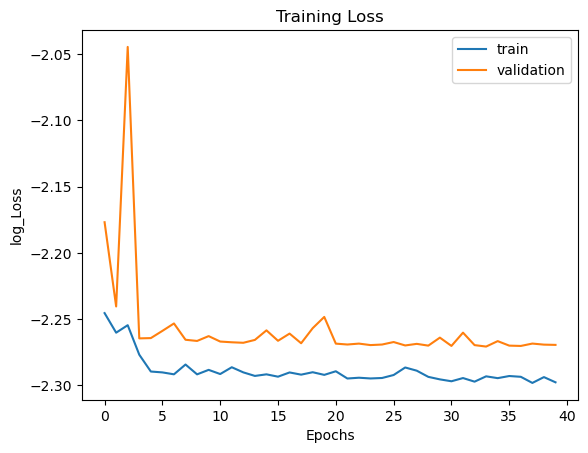

In [241]:
import matplotlib.pyplot as plt

print(len(log_train_loss_list), len(log_val_loss_list))
print(log_train_loss_list, log_val_loss_list)
#绘制loss曲线
plt.plot(log_train_loss_list, label='train')

plt.plot(log_val_loss_list, label='validation')

plt.xlabel('Epochs')
plt.ylabel('log_Loss')
plt.title('Training Loss')
plt.legend()
plt.show()



In [243]:
#测试

#加载模型
model_state_dict = torch.load('CNN.pth')
model.to(device)
model.eval()  # 设置模型为评估模式
criterion = nn.MSELoss()
test_loss = 0.0
right = 0
num = 0
acc_mse = 0
for i, (inputs, labels) in enumerate(test_loader):
    inputs, labels = inputs.cpu(), labels.cpu()
    labels = np.exp(denormalize_peak_flux(labels, scaler))
    print(np.mean(labels))

with torch.no_grad():  # 禁用梯度计算，节省内存
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = outputs.data.cpu().numpy()
        labels = labels.cpu().numpy()
        predicted = np.exp(denormalize_peak_flux(predicted, scaler))
        labels = np.exp(denormalize_peak_flux(labels, scaler))
        '''
        for prediction in predicted:
            prediction[0] = flux_denormalizer(prediction[0])
        labels = [flux_denormalizer(label) for label in labels]
        '''
        mse = np.mean((predicted - labels) ** 2)
        acc_mse += mse
        print(f'测试 Step [{i+1}/{len(test_loader)}], MSE: {mse:.12f}')

        predicted_class = [flux_to_class(p) for p in predicted]
        labels_class = [flux_to_class(l) for l in labels]

        #分析耀斑的级别
        for j in range(len(predicted)):
            num += 1
            '''
            if abs(predicted[j] - labels[j]) < 1e-6:
                right += 1
                print(f'预测正确！预测级别为{predicted_class[j]}, 真实级别为{labels_class[j]}')
                print(f'预测值为{predicted[j]:.9f}, 真实值为{labels[j]:.9f}')
            '''
            if predicted_class[j] == labels_class[j]:
                right += 1
                print(f'预测正确！预测级别为{predicted_class[j]}, 真实级别为{labels_class[j]}')
                print(f'预测值为{predicted[j]:.9f}, 真实值为{labels[j]:.9f}')
            elif predicted_class[j][0] == labels_class[j][0]:
                right += 0.3
                print(f'预测部分正确！预测级别为{predicted_class[j]}, 真实级别为{labels_class[j]}')
                print(f'预测值为{predicted[j]:.9f}, 真实值为{labels[j]:.9f}')
            else:
                right += 0
                print(f'预测错误！预测级别为{predicted_class[j]}, 真实级别为{labels_class[j]}')
                print(f'预测值为{predicted[j]:.9f}, 真实值为{labels[j]:.9f}')
            
accuracy = right / num
print(f'测试集准确率: {accuracy:.4f}')
print(f'MSE:{acc_mse/40}')
#print(f'平均测试损失: {test_loss / len(test_loader):.12f}')

#计算TSS和HSS
tss =  true_skill_statistic(np.array(predicted), np.array(labels), threshold='M')
hss =  heidke_skill_score(np.array(predicted), np.array(labels), threshold='M')
print(f'TSS: {tss:.4f}, HSS: {hss:.4f}')



/tmp/ipykernel_882038/239606473.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load('CNN.pth')


2.7354043845783032e-05
9.395956445425498e-06
1.601249960020295e-05
2.4536764424069534e-06
7.312500032490708e-06
8.207352215162846e-06
1.2761028710899413e-05
2.0816175539807576e-05
1.704411882358542e-05
1.6055146976386534e-05
3.928676476782433e-06
3.3882351600981877e-06
7.898161229459756e-05
2.5243376566383292e-05
1.1937499591309819e-05
5.573529570914926e-06
1.0418014677945482e-05
1.4122425007600542e-05
1.0139705448819979e-06
0.00014821139761653205


/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

测试 Step [1/20], MSE: 0.000000003286
预测部分正确！预测级别为C2, 真实级别为C8
预测值为0.000001991, 真实值为0.000007647
预测部分正确！预测级别为C2, 真实级别为C8
预测值为0.000001911, 真实值为0.000007647
预测正确！预测级别为C2, 真实级别为C2
预测值为0.000001854, 真实值为0.000001529
预测部分正确！预测级别为C2, 真实级别为C1
预测值为0.000001888, 真实值为0.000001412
预测部分正确！预测级别为C2, 真实级别为C1
预测值为0.000001809, 真实值为0.000001153
预测部分正确！预测级别为C2, 真实级别为C1
预测值为0.000001832, 真实值为0.000001176
预测正确！预测级别为C2, 真实级别为C2
预测值为0.000001835, 真实值为0.000001765
预测错误！预测级别为C2, 真实级别为X2
预测值为0.000001955, 真实值为0.000200000
预测错误！预测级别为C2, 真实级别为X2
预测值为0.000002352, 真实值为0.000200000
预测错误！预测级别为C2, 真实级别为M4
预测值为0.000002352, 真实值为0.000037647
预测错误！预测级别为C2, 真实级别为M4
预测值为0.000001843, 真实值为0.000037647
预测错误！预测级别为C2, 真实级别为X1
预测值为0.000001876, 真实值为0.000102353
预测错误！预测级别为C2, 真实级别为X1
预测值为0.000001949, 真实值为0.000102353
预测部分正确！预测级别为C2, 真实级别为C1
预测值为0.000001808, 真实值为0.000001118
预测部分正确！预测级别为C2, 真实级别为C3
预测值为0.000001828, 真实值为0.000002941
预测部分正确！预测级别为C2, 真实级别为C3
预测值为0.000001852, 真实值为0.000002941
预测部分正确！预测级别为C2, 真实级别为C9
预测值为0.000001834, 真实值为0.000009294
预测部分正确！预测级别

/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

测试 Step [9/20], MSE: 0.000000000384
预测错误！预测级别为C2, 真实级别为M3
预测值为0.000001941, 真实值为0.000030588
预测错误！预测级别为C2, 真实级别为M3
预测值为0.000001903, 真实值为0.000030588
预测部分正确！预测级别为C2, 真实级别为C9
预测值为0.000001962, 真实值为0.000009176
预测错误！预测级别为C2, 真实级别为M4
预测值为0.000001910, 真实值为0.000044706
预测错误！预测级别为C2, 真实级别为M4
预测值为0.000002352, 真实值为0.000044706
预测部分正确！预测级别为C2, 真实级别为C9
预测值为0.000001935, 真实值为0.000008824
预测错误！预测级别为C2, 真实级别为M1
预测值为0.000002352, 真实值为0.000012941
预测错误！预测级别为C2, 真实级别为M1
预测值为0.000001926, 真实值为0.000012941
预测部分正确！预测级别为C2, 真实级别为C8
预测值为0.000001949, 真实值为0.000007647
预测错误！预测级别为C2, 真实级别为M2
预测值为0.000001925, 真实值为0.000022353
预测错误！预测级别为C2, 真实级别为M2
预测值为0.000002020, 真实值为0.000022353
预测部分正确！预测级别为C2, 真实级别为C9
预测值为0.000001958, 真实值为0.000009294
预测部分正确！预测级别为C2, 真实级别为C9
预测值为0.000001943, 真实值为0.000009294
预测部分正确！预测级别为C2, 真实级别为C4
预测值为0.000001975, 真实值为0.000004235
预测部分正确！预测级别为C2, 真实级别为C3
预测值为0.000002010, 真实值为0.000002706
预测正确！预测级别为C2, 真实级别为C2
预测值为0.000002019, 真实值为0.000001765
预测正确！预测级别为C2, 真实级别为C2
预测值为0.000001944, 真实值为0.000001765
预测错误！预测级别为C2, 真

/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/aiia/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have